In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
! export TF_CPP_MIN_LOG_LEVEL=2

## Hardware check

In [4]:
# gpu check
!nvidia-smi

Mon Apr 15 14:58:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:3A:00.0 Off |                    0 |
| N/A   34C    P0              39W / 300W |      9MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# check number of cores
import multiprocessing

cores = multiprocessing.cpu_count() 
cores

80

## Environment Prep

In [6]:
cd /pfs/data5/home/hd/hd_hd/hd_nf283/MA_Thesis

/pfs/data5/home/hd/hd_hd/hd_nf283/MA_Thesis


In [7]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
# from tensorflow.keras.models import Model
from tensorflow.keras import models
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import json
from torch.utils.data import Dataset
from transformers import AutoTokenizer, pipeline, AutoModel
import resources.smart_cond as sc
import gc
# from google.colab import files

## Version Check

In [8]:
import tensorflow as tf
print(tf. __version__)

pickle.format_version

2.12.0


'4.0'

## Load Data

In [9]:
data_path = 'Data/sepsis_removed_0.pkl'
pkl = pickle.load(open(data_path, 'rb'))
data = pkl[0]
oc = pkl[1]
train_ind = pkl[2]
valid_ind = pkl[3]
test_ind = pkl[4]
del pkl

In [10]:
data

,ts_ind,hour,variable,value,TABLE,mean,std
0,10223,467.816667,Text,Admission Date: [**2119-5-4**] D...,noteevents,1.000000,1.000000
1,18407,28.016667,Text,Admission Date: [**2112-12-8**] ...,noteevents,1.000000,1.000000
2,40300,155.166667,Text,Admission Date: [**2194-7-18**] ...,noteevents,1.000000,1.000000
3,23747,52.383333,Text,Admission Date: [**2194-1-7**] D...,noteevents,1.000000,1.000000
4,2357,73.133333,Text,Admission Date: [**2186-6-7**] Discharge ...,noteevents,1.000000,1.000000
...,...,...,...,...,...,...,...
82886223,57281,20.400000,MBP,0.195381,chart,78.552377,17.645628
82886224,57281,20.400000,O2 Saturation,-0.678068,chart,96.820961,4.160290
82886225,57281,20.400000,RR,0.179866,chart,26.278501,15.130729
82886226,57281,20.400000,SBP,-0.404061,chart,120.239648,25.341836


In [11]:
data.loc[data['variable'] == 'Text', 'value'] = 1
data

,ts_ind,hour,variable,value,TABLE,mean,std
0,10223,467.816667,Text,1,noteevents,1.000000,1.000000
1,18407,28.016667,Text,1,noteevents,1.000000,1.000000
2,40300,155.166667,Text,1,noteevents,1.000000,1.000000
3,23747,52.383333,Text,1,noteevents,1.000000,1.000000
4,2357,73.133333,Text,1,noteevents,1.000000,1.000000
...,...,...,...,...,...,...,...
82886223,57281,20.400000,MBP,0.195381,chart,78.552377,17.645628
82886224,57281,20.400000,O2 Saturation,-0.678068,chart,96.820961,4.160290
82886225,57281,20.400000,RR,0.179866,chart,26.278501,15.130729
82886226,57281,20.400000,SBP,-0.404061,chart,120.239648,25.341836


In [12]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)
# Remove test patients.
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(test_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(test_sub)]
data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# data[data.variable=='Age'][data.value>200]['value'] = 91.4

In [13]:
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
# train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
rem_sub = oc.loc[~oc.SUBJECT_ID.isin(np.concatenate((train_ind, valid_ind)))].SUBJECT_ID.unique()
bp = int(0.8*len(rem_sub))
# train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
# train_ind = oc.loc[oc.SUBJECT_ID.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.SUBJECT_ID.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
# train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
# fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
# fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op

91626it [00:00, 811607.04it/s]
100%|██████████| 26/26 [04:57<00:00, 11.46s/it]


In [ ]:
# add text features
text_ip = pickle.load(open('Data/hierar/text_emb_input_train_val_1.pkl', 'rb'))

# train_text_ip = text_ip[0]
valid_text_ip = text_ip[1]

# fore_train_ip.append(train_text_ip)
fore_valid_ip.append(valid_text_ip)

In [ ]:
# valid text times
valid_text_times = []
valid_text_varis = []

valid_times = fore_valid_ip[1]
valid_varis = fore_valid_ip[3]

for i in tqdm(range(len(fore_valid_ip[0]))):
    times = []
    varis = []
    for j in range(880):
        if valid_varis[i][j] == 124:
            times.append(valid_times[i][j])
            varis.append(135)
    valid_text_times.append(np.array(times))
    valid_text_varis.append(np.array(varis))

valid_text_times = np.array(valid_text_times)
valid_text_varis = np.array(valid_text_varis)

In [ ]:
from keras.utils import pad_sequences
# padding
padded_valid_text_times = pad_sequences(valid_text_times, maxlen=50, padding='post', dtype='float32')
padded_valid_text_varis = pad_sequences(valid_text_varis, maxlen=50, padding='post')

del valid_text_times, valid_text_varis, valid_times, valid_varis

In [ ]:
fore_valid_ip.append(padded_valid_text_times)
fore_valid_ip.append(padded_valid_text_varis)

In [ ]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]

# ######################################################################################################## 
# ######################################################################################################## 
# class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
# def mortality_loss(y_true, y_pred):
#     sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
#     bce = K.binary_crossentropy(y_true, y_pred)
#     return K.mean(sample_weights*bce, axis=-1)
# ######################################################################################################## 
# ######################################################################################################## 

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

In [ ]:
  
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = sc.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    # demo
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    
    ## text
    # text
    texts = Input(shape=(768*50,))
    text_enc = Dense(1000, activation='relu')(texts)
    text_enc = Dense(d, activation='relu')(text_enc)

    text_2d = Lambda(lambda x: K.reshape(x, (-1, 50, 768)), input_shape=(None, 50*768))(texts)
    
    # Q 
    text_enc = Dense(1000, activation='relu')(texts)
    text_d = Dense(50, activation='relu')(text_enc)
    
    
    # text time
    text_times = Input(shape=(50,))
    cve_units = int(np.sqrt(d))
    text_times_emb = CVE(cve_units, 768)(text_times)
    
    # text varis
    text_varis = Input(shape=(50,))
    # text_varis_emb = Embedding(1+1, d)(text_varis)
    
    text_comb_emb = Add()([text_2d, text_times_emb])
    text_mask = Lambda(lambda x:K.clip(x,0,1))(text_varis)
    # text_mask =  Lambda(lambda x: K.reshape(x, (-1, 50, 768)), input_shape=(None, 50*768))(text_varis)
    text_cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(text_comb_emb, mask=text_mask)
    text_attn_weights = Attention(2*d)(text_cont_emb, mask=text_mask)
    text_fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([text_cont_emb, text_attn_weights])
    
    text_dense_0 = Dense(200, activation='relu')(text_fused_emb)
    text_dense = Dense(50, activation='relu')(text_dense_0)
    
    
    
    ## physio
    # triplet
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    
    
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    
    
    # comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
    
    # comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
    
    # Q
    comb_emb = Add()([varis_emb, values_emb, times_emb, text_d])
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    
#     # embed text input
#     texts = Input(shape=(33792,))
#     text_enc = Dense(1000, activation='relu')(texts)
#     text_enc = Dense(d, activation='relu')(text_enc)


    # conc = Concatenate(axis=-1)([fused_emb, text_fused_emb, demo_enc])
    conc = Concatenate(axis=-1)([fused_emb, text_dense, demo_enc])
    
    
#     fore_op = Dense(V)(conc)
#     op = Dense(1, activation='sigmoid')(fore_op)
#     model = Model([demo, times, values, varis, texts, text_times, text_varis], op)
#     if forecast:
#         fore_model = Model([demo, times, values, varis, texts, text_times, text_varis], fore_op)
#         return [model, fore_model]
#     return model

    
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis, texts, text_times, text_varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis, texts, text_times, text_varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

In [ ]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
# lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())

val_losses = []

for i in list(range(100)):
    gc.collect()
    fore_path = 'hierar/Pro/models/forecasting/forecasting_'+str(i+1)+'_epochs.h5'
    fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
    fore_model.load_weights(fore_path)

    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    val_losses.append(val_loss)
    print(f'validation loss: {val_loss}')
    gc.collect()
    print(val_losses)

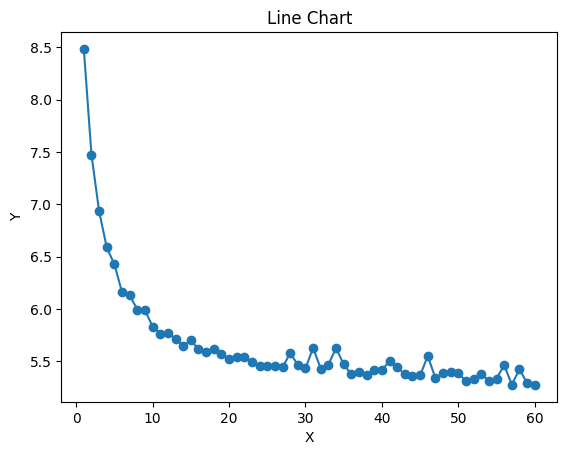

In [4]:
import matplotlib.pyplot as plt

# List of y values
y_values = [8.483444213867188, 7.473776340484619, 6.93328857421875, 6.587220191955566, 6.426333904266357, 6.160365581512451, 6.131229400634766, 5.9929986000061035, 5.9875593185424805, 5.831292152404785, 5.763743877410889, 5.772653579711914, 5.716346263885498, 5.6492919921875, 5.701827526092529, 5.616291522979736, 5.586249828338623, 5.613157272338867, 5.566737651824951, 5.521819591522217, 5.539564609527588, 5.536924839019775, 5.491822719573975, 5.4548139572143555, 5.457018852233887, 5.455965995788574, 5.44157600402832, 5.579344272613525, 5.466297626495361, 5.432507514953613, 5.6279473304748535, 5.4310126304626465, 5.467263221740723, 5.627671241760254, 5.470911502838135, 5.374270439147949, 5.393491744995117, 5.368008136749268, 5.416056156158447, 5.413441181182861, 5.505258560180664, 5.4463725090026855, 5.374141216278076, 5.357137203216553, 5.3646159172058105, 5.550652980804443, 5.341265678405762, 5.385351657867432, 5.3984479904174805, 5.38784122467041, 5.3086395263671875, 5.329946517944336, 5.377668380737305, 5.3150634765625, 5.335404872894287, 5.463996887207031, 5.278020858764648, 5.423778533935547, 5.292324542999268, 5.274566173553467, 5.356962203979492, 5.326461315155029, 5.3152174949646, 5.37034797668457, 5.29688835144043, 5.330498218536377, 5.288092613220215, 5.28347635269165, 5.2894158363342285, 5.286518096923828, 5.304732799530029, 5.317917823791504, 5.2567267417907715, 5.24439001083374, 5.268968105316162, 5.260003566741943, 5.304421901702881, 5.303035259246826, 5.258347511291504]

y_values += [5.270775318145752, 5.240047931671143, 5.3805413246154785, 5.247272968292236, 5.260074615478516, 5.228386878967285, 5.242153644561768, 5.245741367340088, 5.242713451385498, 5.220280170440674, 5.243130683898926, 5.388330459594727, 5.280952453613281, 5.333823204040527, 5.244796276092529, 5.260797500610352, 5.231106758117676, 5.2983317375183105, 5.205908298492432, 5.238000869750977, 5.256564140319824, 5.208333492279053, 5.183602333068848, 5.260712146759033, 5.221482753753662, 5.195287704467773, 5.250069618225098, 5.242126941680908, 5.225848197937012, 5.317182540893555, 5.225686073303223, 5.2749762535095215, 5.207957744598389, 5.465452194213867, 5.27269172668457, 5.251333713531494, 5.207937240600586, 5.197074890136719, 5.179708003997803, 5.172123908996582, 5.222113609313965, 5.1610565185546875, 5.186363697052002, 5.2389068603515625, 5.284305572509766, 5.3309645652771, 5.207242965698242, 5.168575763702393, 5.154052734375, 5.206447601318359, 5.269092082977295, 5.201481342315674, 5.179599285125732]

y_values = y_values[:60]
# Generating x values
x_values = list(range(1, len(y_values) + 1))

# Creating the line chart
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Adding title and labels
plt.title('Line Chart')
plt.xlabel('X')
plt.ylabel('Y')

# Displaying the chart
plt.show()


In [ ]:
# val_losses = [8.483444213867188, 7.473776340484619, 6.93328857421875, 6.587220191955566, 6.426333904266357, 6.160365581512451, 6.131229400634766, 5.9929986000061035, 5.9875593185424805, 5.831292152404785, 5.763743877410889, 5.772653579711914, 5.716346263885498, 5.6492919921875, 5.701827526092529, 5.616291522979736, 5.586249828338623, 5.613157272338867, 5.566737651824951, 5.521819591522217, 5.539564609527588, 5.536924839019775, 5.491822719573975, 5.4548139572143555, 5.457018852233887, 5.455965995788574, 5.44157600402832, 5.579344272613525, 5.466297626495361, 5.432507514953613, 5.6279473304748535, 5.4310126304626465, 5.467263221740723, 5.627671241760254, 5.470911502838135, 5.374270439147949, 5.393491744995117, 5.368008136749268, 5.416056156158447, 5.413441181182861, 5.505258560180664, 5.4463725090026855, 5.374141216278076, 5.357137203216553, 5.3646159172058105, 5.550652980804443, 5.341265678405762, 5.385351657867432, 5.3984479904174805, 5.38784122467041, 5.3086395263671875, 5.329946517944336, 5.377668380737305, 5.3150634765625, 5.335404872894287, 5.463996887207031, 5.278020858764648, 5.423778533935547, 5.292324542999268, 5.274566173553467, 5.356962203979492, 5.326461315155029, 5.3152174949646, 5.37034797668457, 5.29688835144043, 5.330498218536377, 5.288092613220215, 5.28347635269165, 5.2894158363342285, 5.286518096923828, 5.304732799530029, 5.317917823791504, 5.2567267417907715, 5.24439001083374, 5.268968105316162, 5.260003566741943, 5.304421901702881, 5.303035259246826, 5.258347511291504]

In [ ]:
# lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
# # lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
# d, N, he, dropout = 50, 2, 4, 0.2
# model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print (fore_model.summary())

# val_losses = []

# for i in list(range(100)):
#     gc.collect()
#     fore_path = 'hierar/Pro/models/forecasting/forecasting_'+str(i+80)+'_epochs.h5'
#     fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
#     fore_model.load_weights(fore_path)

#     val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
#     val_losses.append(val_loss)
#     print(f'validation loss: {val_loss}')
#     gc.collect()
#     print(val_losses)

In [ ]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
# lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())
gc.collect()
fore_path = 'hierar/Pro/models/forecasting/forecasting_103_epochs.h5'
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_path)

val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
print(f'validation loss: {val_loss}')
gc.collect()

In [25]:
val_loss

5.260712146759033